## Land Use land cover analysis using Hyperspectral Remote Sensing data adopting AutoEncoders

In [ ]:
### Libraries

In [14]:
location = 'dataset/'

from IPython.core.display import display, HTML
from IPython.display import display_html
display(  HTML( '<style>.container { width:60% !important; }</style>' )  )


import os, random, time, datetime
import pandas as pd, re
import numpy as np,  seaborn as sns
from numpy import savetxt
from numpy import genfromtxt
import sklearn, scipy
from sklearn import *
import missingno as msno
import xgboost as xgb

from glob import glob
from scipy.io import loadmat

from tqdm import tqdm

import scipy.stats as stats, random, math

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import *
from matplotlib.colors import ListedColormap

plt.style.use('classic')

# import remote sensing libraries
import geopandas as pdd
# import rasterio as rio
# import shapely
# import earthpy.plot as ep
# import earthpy.spatial as es

# from osgeo import gdal

# ml ai lib 
import tensorflow as tf, imageio, PIL
from tensorflow import *
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras import models
from tensorflow.keras.callbacks import *
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split
import keras_tuner as ktuner 

%matplotlib inline

## Set Jupyter notebook display options for pandas
pd.set_option('display.max_columns', None)
pd.options.display.max_rows = 6

C:\Users\madhur\AppData\Local\Temp\ipykernel_15968\1996665092.py:3: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


<br> 

### Basic architecture of an Auto-Encoder:

    Encoder
    Latent View Representation
    Decoder
    Reconstruction Loss/Error
<br>

### data

The Hyperspectral Remote Sensing data has 103 spectral bands containing 610 * 340 pixels with the geometric resolution 1.3 m. The groundtruth of the HSI is differentiated into 9 classes as:


| Label | Class | 
| -: | :- |
| 1 | Asphalt |
| 2 | Meadows |
| 3 | Gravel |
| 4 | Trees |
| 5 | Painted metal sheets |
| 6 | Bare Soil |
| 7 | Bitumen |
| 8 | Self-Blocking Bricks |
| 9 | Shadows |


In [7]:
data = loadmat( location+'hyperspectral_ae/hyperspectral_rs_data.mat' )['paviaU']

gt = loadmat( location+'hyperspectral_ae/building_data_label.mat' )['paviaU_gt']

print( f'Data Shape: {data.shape[:-1]}\nNumber of Bands: {data.shape[-1]}' )

df = pd.DataFrame(data.reshape(data.shape[0]*data.shape[1], -1))

df.columns = [f'band{i}' for i in range(1, df.shape[-1]+1)]

df['class'] = gt.ravel()

Data Shape: (610, 340)
Number of Bands: 103


#### remote sensing data standarization

In [8]:
from sklearn.preprocessing import StandardScaler

In [9]:
stdScaler_Obj = StandardScaler()

standarized_data_np =  stdScaler_Obj.fit_transform(  df.drop( columns= 'class' )  )

X_scaled = pd.DataFrame( standarized_data_np, columns= df.drop( columns= 'class' ) .columns )

X_scaled

,band1,band2,band3,band4,band5,band6,band7,band8,band9,band10,...,band94,band95,band96,band97,band98,band99,band100,band101,band102,band103
0,-0.626257,-0.749766,-0.681465,-0.832438,-0.970595,-0.896649,-0.790805,-0.831873,-0.852034,-0.825394,...,1.340807,1.331218,1.256568,1.190524,1.176212,1.169092,1.182228,1.204290,1.200228,1.180516
1,-0.723011,-0.649438,-0.553828,-0.673116,-0.813957,-0.795699,-0.839753,-0.845079,-0.806836,-0.787690,...,0.396737,0.366372,0.326889,0.307095,0.317867,0.317740,0.285445,0.262622,0.272271,0.325231
2,-0.684759,-0.222510,-0.495075,-0.853302,-0.981398,-0.929719,-0.944399,-0.907808,-0.793922,-0.803400,...,0.022584,0.024679,-0.018388,-0.066617,-0.053081,-0.016029,0.041307,0.100640,0.129600,0.127402
3,-0.648758,-0.551244,-0.644997,-0.481550,-0.579899,-0.957567,-1.106432,-1.036568,-1.018300,-0.952646,...,0.488248,0.472933,0.409708,0.344940,0.365887,0.402391,0.407513,0.420977,0.459301,0.462646
4,-0.675759,-0.619553,-0.649049,-0.853302,-0.815757,-0.858358,-0.961277,-1.020060,-0.956959,-0.886664,...,0.185914,0.145140,0.100593,0.046916,0.098179,0.213740,0.232266,0.194928,0.232707,0.239940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207395,-0.790513,-0.546975,-0.600426,-0.756571,-0.651916,-0.680825,-0.768863,-0.798858,-0.761638,-0.622733,...,-0.153487,-0.135163,-0.117538,-0.109192,-0.092697,-0.105517,-0.149652,-0.178596,-0.192907,-0.139134
207396,-0.990771,-0.440243,-0.185100,-0.432236,-0.587100,-0.592059,-0.674344,-0.747684,-0.698683,-0.643156,...,-0.051551,-0.003120,0.043435,0.038637,0.022549,0.044437,0.073939,0.059540,0.044478,0.005388
207397,-0.747762,-0.988845,-0.754400,-0.661736,-0.648316,-0.769591,-0.848192,-0.731177,-0.621200,-0.746843,...,0.140738,0.146298,0.174081,0.217215,0.200220,0.162949,0.189965,0.190093,0.203933,0.200848
207398,-0.747762,-0.211836,-0.294503,-0.667426,-0.588901,-0.477185,-0.593328,-0.683305,-0.677698,-0.591313,...,0.087453,0.084910,0.087761,0.097769,0.050160,0.015413,0.058227,0.105475,0.085241,0.042111


<br>

#### Visualize Data 
<br>

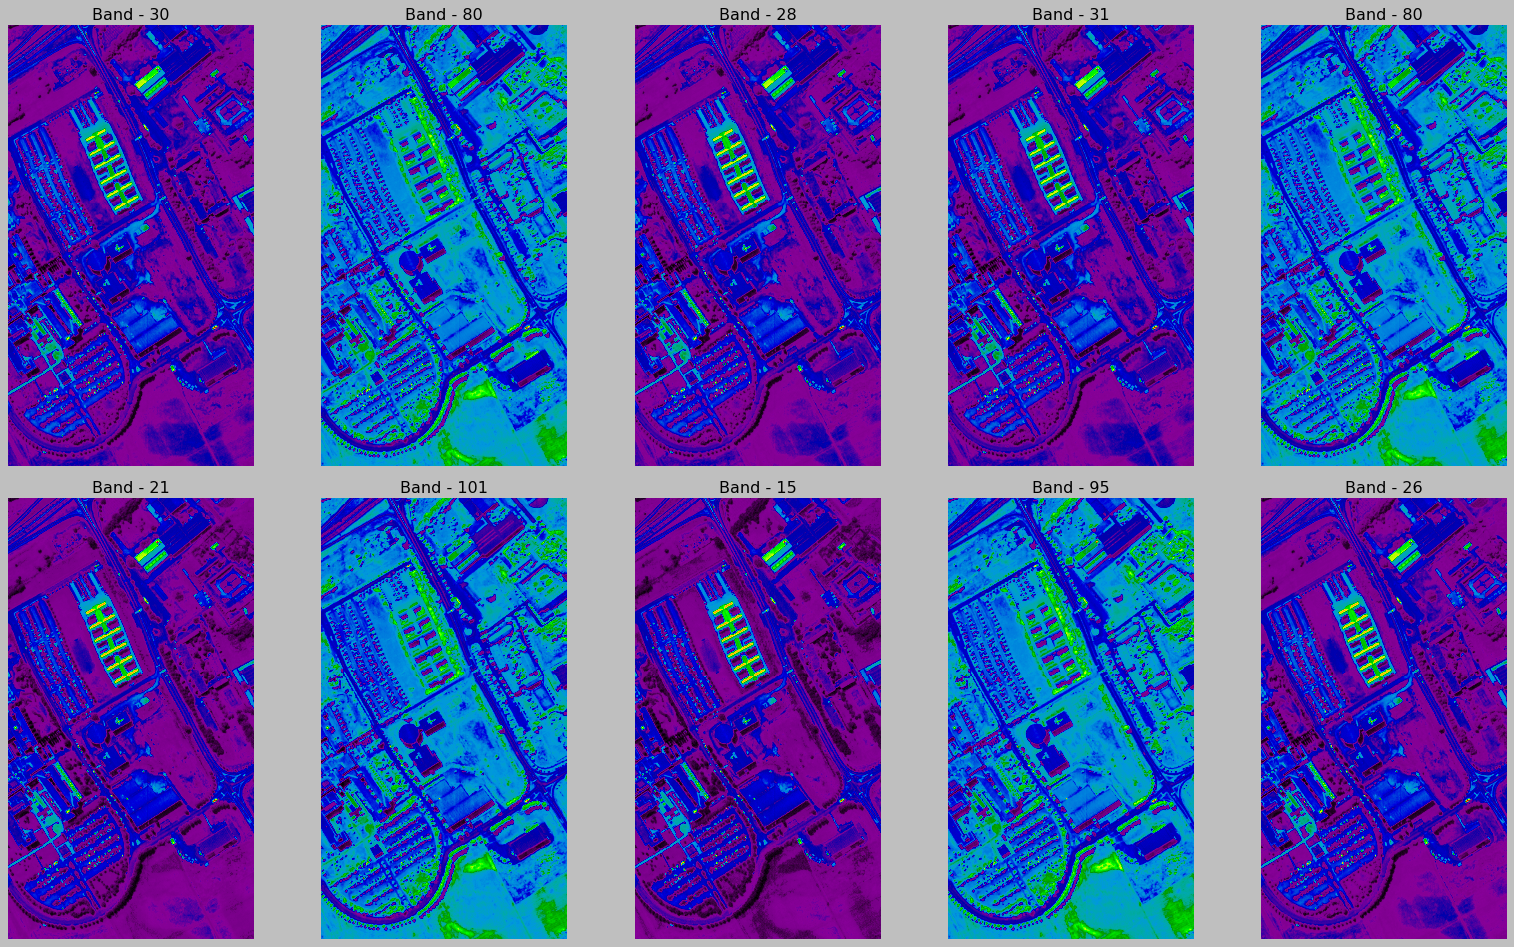

In [10]:
# radomly plot 10 out of 103 spectral bands 

fig = plt.figure(figsize = (20, 12))

ax = fig.subplots(2, 5)

for i in range(2):
  for j in range(5):
    c = np.random.randint(103)
    ax[i][j].imshow(data[:, :, c], cmap='nipy_spectral')
    ax[i][j].axis('off')
    ax[i][j].title.set_text(f"Band - {c}")
    c+=1

plt.tight_layout()
plt.show()

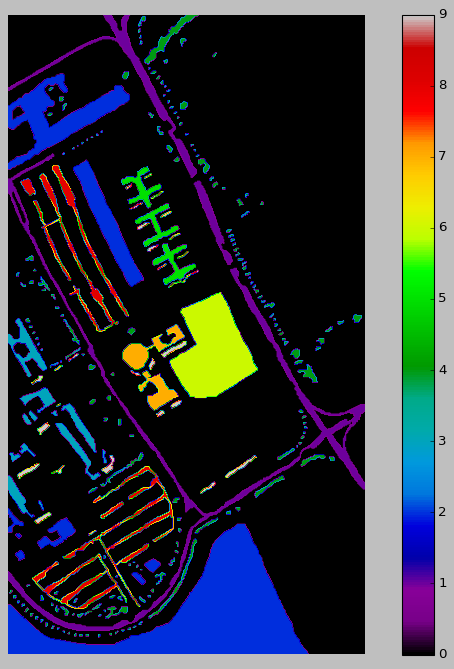

In [11]:
## visualize the ground truth 
# the black color pixels means no information and we will discard it prior to classification

def plot_data(data):
  fig = plt.figure(figsize=(12, 10))
  plt.imshow(data, cmap='nipy_spectral')
  plt.colorbar()
  plt.axis('off')
  plt.show()

plot_data(gt)

<br>

### Develop `AutoEncoder` Deep Learning Neural Network<br>

In [15]:
# encoder dimension
from tensorflow.keras.models import Model


encoding_dim = 60
ncol = X_scaled.shape[-1]

input_dim = Input( shape = (ncol, ), name = 'InputLayer' )  # <-- check shape

# Encoder Layers
encoded1 = Dense(100, activation = 'relu', name = 'EncodeLayer1')(input_dim)
encoded2 = Dense(90, activation = 'relu', name = 'EncodeLayer2')(encoded1)
encoded3 = Dense(85, activation = 'relu', name = 'EncodeLayer3')(encoded2)
encoded4 = Dense(80, activation = 'relu', name = 'EncodeLayer4')(encoded3)
encoded5 = Dense(75, activation = 'relu', name = 'EncodeLayer5')(encoded4)
encoded6 = Dense(70, activation = 'relu', name = 'EncodeLayer6')(encoded5)

# Coded Part
encoded7 = Dense(encoding_dim, activation = 'linear', name = 'CodeLayer')(encoded6)

# Decoder Layers
decoded1 = Dense(70, activation = 'relu', name = 'DecodeLayer1')(encoded7)
decoded2 = Dense(75, activation = 'relu', name = 'DecodeLayer2')(decoded1)
decoded3 = Dense(80, activation = 'relu', name = 'DecodeLayer3')(decoded2)
decoded4 = Dense(85, activation = 'relu', name = 'DecodeLayer4')(decoded3)
decoded5 = Dense(90, activation = 'relu', name = 'DecodeLayer5')(decoded4)
decoded6 = Dense(100, activation = 'relu', name = 'DecodeLayer6')(decoded5)
decoded7 = Dense(ncol, activation = 'sigmoid', name = 'OutputLayer')(decoded6)

# Combine Encoder and Deocder layers
autoencoder = Model(inputs = input_dim, outputs = decoded7)

autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 103)]             0         
                                                                 
 EncodeLayer1 (Dense)        (None, 100)               10400     
                                                                 
 EncodeLayer2 (Dense)        (None, 90)                9090      
                                                                 
 EncodeLayer3 (Dense)        (None, 85)                7735      
                                                                 
 EncodeLayer4 (Dense)        (None, 80)                6880      
                                                                 
 EncodeLayer5 (Dense)        (None, 75)                6075      
                                                                 
 EncodeLayer6 (Dense)        (None, 70)                5320  

<br>

### Training AutoEncoder
<br>

In [16]:
# Compile the Model

autoencoder.compile(  optimizer = 'adam', loss = 'mse', 
                      metrics = [ keras.metrics.MeanSquaredLogarithmicError() ]
                   ) 

# Callbacks

## Early Stopping
early_stop = EarlyStopping(  monitor = 'mean_squared_logarithmic_error',
                             mode = 'min', min_delta = 1e-1, patience = 20,
                             restore_best_weights = True  )

# Fit the Model
hist = autoencoder.fit(  X_scaled, X_scaled, 
                         epochs = 100, batch_size = 256 ,  shuffle = True, 
                         callbacks= [ early_stop ]  )

Epoch 1/100
811/811 [==============================] - 6s 6ms/step - loss: 0.6109 - mean_squared_logarithmic_error: 0.0309
Epoch 2/100
811/811 [==============================] - 5s 6ms/step - loss: 0.5892 - mean_squared_logarithmic_error: 0.0250
Epoch 3/100
811/811 [==============================] - 5s 6ms/step - loss: 0.5876 - mean_squared_logarithmic_error: 0.0243
Epoch 4/100
811/811 [==============================] - 5s 6ms/step - loss: 0.5870 - mean_squared_logarithmic_error: 0.0241
Epoch 5/100
811/811 [==============================] - 5s 6ms/step - loss: 0.5863 - mean_squared_logarithmic_error: 0.0238
Epoch 6/100
811/811 [==============================] - 5s 6ms/step - loss: 0.5860 - mean_squared_logarithmic_error: 0.0236
Epoch 7/100
811/811 [==============================] - 5s 6ms/step - loss: 0.5859 - mean_squared_logarithmic_error: 0.0235
Epoch 8/100
811/811 [==============================] - 5s 6ms/step - loss: 0.5856 - mean_squared_logarithmic_error: 0.0234
Epoch 9/100
811/

<br>

#### Encode data

After training the autoencoder, separate the encoder part and feed the data which results in the latent space representation of the original data. The below code servers the above-mentioned purpose.

<br>

In [17]:
# Seperate encoder part
encoder = Model( inputs = input_dim, outputs = encoded7 )

# Summary
encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 103)]             0         
                                                                 
 EncodeLayer1 (Dense)        (None, 100)               10400     
                                                                 
 EncodeLayer2 (Dense)        (None, 90)                9090      
                                                                 
 EncodeLayer3 (Dense)        (None, 85)                7735      
                                                                 
 EncodeLayer4 (Dense)        (None, 80)                6880      
                                                                 
 EncodeLayer5 (Dense)        (None, 75)                6075      
                                                                 
 EncodeLayer6 (Dense)        (None, 70)                5320

In [18]:
# Get the data with the reduced dimesion

encoded_X = pd.DataFrame( encoder.predict(X_scaled) )

encoded_X = encoded_X.add_prefix( 'feature_' )

encoded_X['class'] = df.loc[ :,['class'] ]

# Save Data
encoded_X.to_csv( location + 'reduced_data.csv' )

In [56]:
# ep.plot_bands(data[:10, :, :], title=[f'Band-{i}' for i in range(1, 11)], 
#               cmap='gist_gray', cols=5, cbar=False, scale=True, figsize=(14, 10))
# plt.show()

In [24]:
ae_df = pd.read_csv(  location+'reduced_data.csv', index_col= 0  )
ae_df.head()

# Removing pixels which has label as 0.
res_df = ae_df[ae_df['class'] != 0]
res_df.shape

X = res_df.iloc[:, :-1].values
y = res_df.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.70, stratify = y.ravel())
print(  f"X_train Shape: {X_train.shape} \n\
X_test Shape: {X_test.shape}\n\
y_train Shape: {y_train.shape}\n\
y_test Shape:{y_test.shape}")

X_train Shape: (12832, 60) 
X_test Shape: (29944, 60)
y_train Shape: (12832,)
y_test Shape:(29944,)


<br>

#### K-Nearest Neighbor Classifier

In [26]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 10)

knn.fit(X_train, y_train)

knn_pred = knn.predict(X_test)

print(f"Accuracy: {sklearn.metrics.accuracy_score(y_test, knn_pred)*100}\n")
print(sklearn.metrics.classification_report(y_test, knn_pred))

Accuracy: 81.92626235639861

              precision    recall  f1-score   support

           1       0.88      0.86      0.87      4642
           2       0.82      0.97      0.89     13055
           3       0.51      0.47      0.49      1469
           4       0.95      0.78      0.86      2145
           5       0.98      0.99      0.99       942
           6       0.76      0.37      0.50      3520
           7       0.70      0.69      0.69       931
           8       0.73      0.78      0.75      2577
           9       1.00      1.00      1.00       663

    accuracy                           0.82     29944
   macro avg       0.82      0.77      0.78     29944
weighted avg       0.82      0.82      0.81     29944



In [44]:
from tqdm.notebook import tqdm

def predict_class(df, cls, name=None):
  if name!='lgb':
    pred = [0 if df.iloc[i, :][-1] == 0 else cls.predict(df.iloc[i, :][:-1].values.reshape(1,-1))[0]
          for i in tqdm(range(df.shape[0]))]
  else:
    pred = [0 if df.iloc[i, :][-1] == 0 else np.argmax(cls.predict(df.iloc[i, :][:-1].values.reshape(1,-1)), axis=1)[0]
          for i in tqdm(range(df.shape[0]))]
  return np.array(pred)

<br>

### support vector machine SVM


In [46]:
svm.predict(X_test)

array([2, 1, 2, ..., 2, 2, 1], dtype=int64)

In [49]:

from sklearn.svm import SVC

svm = SVC(C = 5.0, kernel = 'rbf', cache_size = 4*1024)

svm.fit(X_train, y_train)

svm_pred = svm.predict(X_test)

# Accuracy 
print( f"Accuracy: {sklearn.metrics.accuracy_score(y_test, svm_pred)*100}" )
print( sklearn.metrics.classification_report(y_test, svm_pred) )

Accuracy: 78.56665776115416
              precision    recall  f1-score   support

           1       0.77      0.93      0.84      4642
           2       0.79      0.99      0.88     13055
           3       0.38      0.01      0.01      1469
           4       0.93      0.75      0.83      2145
           5       0.99      0.99      0.99       942
           6       0.94      0.19      0.31      3520
           7       0.47      0.01      0.01       931
           8       0.63      0.94      0.75      2577
           9       1.00      1.00      1.00       663

    accuracy                           0.79     29944
   macro avg       0.77      0.64      0.63     29944
weighted avg       0.78      0.79      0.73     29944



In [55]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report

d_train = lgb.Dataset(X_train, label=y_train)

# Parameters
params={}
params['learning_rate']=0.08
params['boosting_type']='gbdt' #GradientBoostingDecisionTree
params['objective']='multiclass' #Multi-class target feature
params['metric']='multi_logloss' #metric for multi-class
params['max_depth']=25
params['num_class']=10 #no.of unique values in the target class not inclusive of the end value

clf = lgb.train(params, d_train, 100)

# prediction
lgb_predictions = clf.predict(X_test)
lgb_pred = np.argmax( lgb_predictions, axis= 1 )

# Accuracy and Classification Report
print( f"Accuracy: {accuracy_score(y_test, lgb_pred)*100}" )
print( classification_report(y_test, lgb_pred) )

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15300
[LightGBM] [Info] Number of data points in the train set: 12832, number of used features: 60
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -1.864310
[LightGBM] [Info] Start training from score -0.830247
[LightGBM] [Info] Start training from score -3.013978
[LightGBM] [Info] Start training from score -2.636411
[LightGBM] [Info] Start training from score -3.460761
[LightGBM] [Info] Start training from score -2.140495
[LightGBM] [Info] Start training from score -3.470736
[LightGBM] [In